In [1]:
from dreimac import ComplexProjectiveCoords
from dreimac.utils import GeometryExamples, PlotUtils, CircleMapUtils

import matplotlib.pyplot as plt
%matplotlib widget

import gudhi

import numpy as np
%load_ext autoreload
%autoreload 2

number of faces:  4


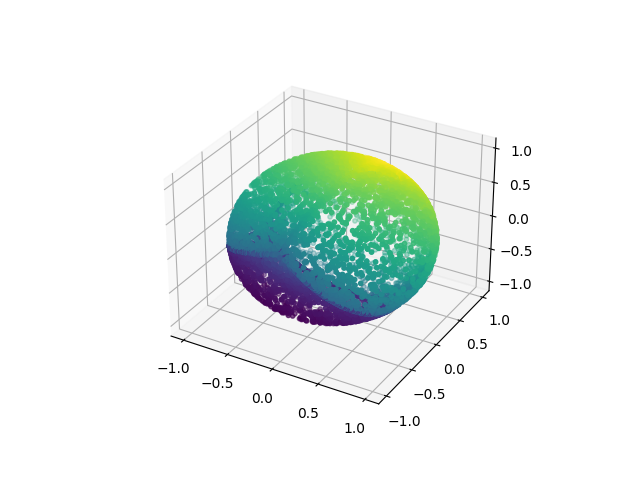

In [43]:
data = GeometryExamples.sphere(10000)

cpc = ComplexProjectiveCoords(data, n_landmarks=200)

projData = cpc.get_coordinates()

hopf_map = np.array([
    2*(np.prod(projData[[0,2],:],axis=0) + np.prod(projData[[1,3],:],axis=0)),
    2*(np.prod(projData[[1,2],:],axis=0) - np.prod(projData[[0,3],:],axis=0)),
    np.sum(projData[[0,1],:]**2,axis=0) - np.sum(projData[[2,3],:]**2,axis=0)
])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(hopf_map[0], hopf_map[1], hopf_map[2],s=10, c=data[:,2])


---

In [ ]:
np.random.seed(0)
data = 2 * np.random.random_sample((10000, 3)) - 1
data = data / np.linalg.norm(data, axis=1)[:, np.newaxis]



#data = np.array(
#    [
#        [0, 0, 1],
#        [2 * np.sqrt(2) / 3, 0, -1 / 3],
#        [-np.sqrt(2) / 3, np.sqrt(2 / 3), -1 / 3],
#        [-np.sqrt(2) / 3, -np.sqrt(2 / 3), -1 / 3],
#        #[0,1,0],
#        #[1,0,0],
#        np.array([1,1,0])/np.sqrt(2),
#        np.array([1,0,1])/np.sqrt(2),
#        np.array([0,1,1])/np.sqrt(2),
#        np.array([1,1,1])/np.sqrt(3),
#        -np.array([1,1,0])/np.sqrt(2),
#        -np.array([1,0,1])/np.sqrt(2),
#        -np.array([0,1,1])/np.sqrt(2),
#        -np.array([1,1,1])/np.sqrt(3),
#    ]
#)

cocycle_simplices = np.array(
[
    [1, 2, 3],
    [1, 3, 4],
    [1, 2, 4],
    [2, 3, 4]
])

integer_cocycle = np.array([1, 0, 0, 0])

delta_1 = np.array(
    [[1, -1, 0, 1, 0, 0], [0, 1, -1, 0, 0, 1], [1, 0, -1, 0, 1, 0], [0, 0, 0, 1, -1, 1]]
)


nu = np.linalg.lstsq(delta_1, integer_cocycle)[0]
print("nu", nu)
# hardcoded
#nu = np.array([0.75, 0, 0.5, 0, 0, 0.25])

cocycle_values = integer_cocycle - delta_1 @ nu

print("cocycle values", cocycle_values)

# all good so far

# squareform = np.zeros((nu.shape[0],nu.shape[0]))
# for i in range(squareform.shape[0]):
#    for j in range(squareform.shape[1]):
#        squareform[i,j] = np.linalg.norm(nu[i] - nu[j])

nu = scipy.spatial.distance.squareform(nu)

nu = nu - 2 * np.tril(nu)
print("nu", nu)

N, d = data.shape

s = landmarks.shape[0]
c = cocycle_simplices.shape[0] + 1

# print(N,d, s,c)

# NOTE: taking minimum between numbers and 1 because
# when number is slighlty larger than 1 get nan with arccos
dist_land_land = np.arccos(np.minimum(landmarks @ landmarks.T, 1))

# print(dist_land_land)
# print(np.diag(dist_land_land))
# print(np.diag(np.diag(dist_land_land)))

# this doesn't do anything...
# dist_land_land = dist_land_land - np.diag(np.diag(dist_land_land))

dist_land_data = np.arccos(np.minimum(landmarks @ data.T, 1))

#print("dist_land_data", dist_land_data)

# print(dist_land_land)
# print(dist_land_data)

r = np.sort(dist_land_land, axis=1)[:, 1]

# print(r)

import numpy.matlib

U = dist_land_data < np.matlib.repmat(r, N, 1).T
# dist_land_data.shape
print("U", U)


#print("size of U", np.linalg.norm(U))

phi = np.zeros((s, N))

for j in range(0, s):
    phi[j, U[j, :]] = (r[j] - dist_land_data[j, U[j, :]]) ** 2

#print("norm of phi", np.linalg.norm(phi))

sum_phi = np.sum(phi, axis=0)
# print(sum_phi.shape)
# print(phi.shape)
varphi = phi / sum_phi[np.newaxis, :]

print("varphi", varphi)
#print("norm varphi", np.linalg.norm(varphi))


indx = np.zeros(N, dtype=int)

for j in range(N):
    indx[j] = np.argwhere(U[:, j])[0][0]

# NOTE: the cover is not great
#print("idx counts", sum(indx[indx==0].shape),sum(indx[indx==1].shape),sum(indx[indx==2].shape))
print("indx", indx)


theta = np.zeros((s, s, s))

p = np.array(
    [
        [3, 2, 1],
        [3, 1, 2],
        [2, 3, 1],
        [2, 1, 3],
        [1, 3, 2],
        [1, 2, 3],
    ]
) - 1
p = p.flatten()
#reshape(p.shape[0] * p.shape[1])

ind_theta = cocycle_simplices[:,p]
print("ind_theta", ind_theta)

# NOTE: this was failing because for slicing its [start:end:step] and I was using [start:step:end]
lin_ind_theta = ind_theta[:,::3] + s * (ind_theta[:,1::3] - 1) + s**2 * (ind_theta[:,2::3]-1) - 1
print("lin_ind_theta", lin_ind_theta)
lin_ind_theta = lin_ind_theta.flatten()
print("lin_ind_theta", lin_ind_theta)

val_theta = np.matlib.repmat(cocycle_values, 6, 1).T
#print(val_theta.shape)
#print("val_theta", val_theta)

a = ind_theta[:,1::3] - ind_theta[:,::3]
b = ind_theta[:,2::3] - ind_theta[:,::3]
c = ind_theta[:,2::3] - ind_theta[:,1::3]

val_theta = np.sign(a * b * c) * val_theta
#print("val_theta", val_theta)
#val_theta = val_theta.flatten()
print("val_theta", val_theta)

#theta[np.unravel_index(lin_ind_theta,(s,s,s))] = val_theta
theta = theta.flatten()
# HARDCODED: I put a minus sign
#theta[np.unravel_index(lin_ind_theta,(s,s,s))] = -val_theta.T.flatten()
theta[lin_ind_theta] = val_theta.flatten()
theta = theta.reshape((s,s,s)).T
print("theta")
print(theta[:,:,0])
print(theta[:,:,1])
print(theta[:,:,2])
print(theta[:,:,3])
#theta[np.unravel_index(lin_ind_theta,(s,s,s))] = val_theta

#theta[:,:,0] = np.array([
#[0,         0,         0,         0],
#[0,         0,    0.2500,   -0.2500],
#[0,   -0.2500,         0,    0.2500],
#[0,    0.2500,   -0.2500,         0]
#])
#
#theta[:,:,1] = np.array([
#[         0,         0,   -0.2500,    0.2500],
#[         0,         0,         0,         0],
#[    0.2500,         0,         0,   -0.2500],
#[   -0.2500,         0,    0.2500,         0]
#])
#
#theta[:,:,2] = np.array([
#[         0,    0.2500,         0,   -0.2500],
#[   -0.2500,         0,         0,    0.2500],
#[         0,         0,         0,         0],
#[    0.2500,   -0.2500,         0,         0]
#])
#
#theta[:,:,3] = np.array([
#[         0,   -0.2500,    0.2500,         0],
#[    0.2500,         0,   -0.2500,         0],
#[   -0.2500,    0.2500,         0,         0],
#[         0,         0,         0,       0]
#])

h = np.zeros((s,s,N), dtype=complex)

for j in range(s):
    for k in range(s):
        h[j,k] = np.exp( 2 * np.pi * 1j * (theta[j,k,:] @ varphi + nu[j,k]))
        
class_map = np.array(np.sqrt(varphi),dtype=complex)

for j in range(N):
    h_k_ind_j = h[:,indx[j]]
    class_map[:,j] = class_map[:,j] * np.conjugate(h_k_ind_j[:,j])
    
#print("class map", class_map)
#print("norm class map", np.linalg.norm(class_map))
print("class map ", class_map)


# NOTE: do we need f for anything?
#f = np.zeros((2 * class_map.shape[0], class_map.shape[1]))
#f[::2,:] = np.real(class_map)
#f[1::2,:] = np.imag(class_map)

X = class_map
#variance = np.zeros(X.shape[0])
# dimension of projective space to project onto
proj_dim = 1

#for i in range(class_map.shape[0]-proj_dim-1):
for i in [1,2]:
    UU, S, _ = np.linalg.svd(X)
    print("singular vals", S)
    #print("norm UU", np.linalg.norm(UU))
    print("norm X", np.linalg.norm(X,axis=1))
    #variance[-i] = np.mean(
    #    (np.pi/2 - np.arccos(np.abs(UU[:,-1].T @ X)))**2
    #)
    Y = np.conjugate(UU.T) @ X
    y = Y[-1,:]
    print(np.linalg.norm(y))
    Y = Y[:-1,:]
    #print(Y.shape)
    print(np.sqrt( 1 - np.abs(y)**2 ).shape)
    X = np.divide(Y, np.sqrt( 1 - np.abs(y)**2 ))
    print("X", X)
    
Z = np.zeros((2 * X.shape[0], X.shape[1]))
Z[::2,:] = np.real(X)
Z[1::2,:] = np.imag(X)
projData = Z
    
#XX = X
#print(np.linalg.norm(XX))

#for j in [1]:
#    UU, _, _ = np.linalg.svd(XX)
#    print("norm UU", np.linalg.norm(UU))
#    #variance[-i] = np.mean(
#    #    (np.pi/2 - np.arccos(np.abs(UU[:,-1].T @ X)))**2
#    #)
#    Y = UU.T @ XX
#    #print(np.linalg.norm(Y,axis=1))
#    y = Y[-1,:]
#    #print(np.linalg.norm(y))
#    Y = Y[:-1,:]
#    XX = Y / np.sqrt( 1 - np.abs(y)**2 )


---

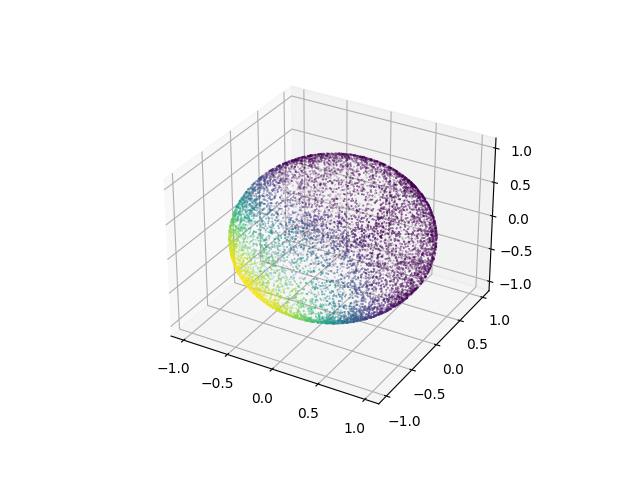

In [112]:
%matplotlib widget
  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2],s=0.1, c=varphi[3])
